In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely.geometry as geom
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
from shapely.geometry import box
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import rioxarray 
import matplotlib.dates as mdates
import cartopy.mpl.ticker as cticker
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import TwoSlopeNorm

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
experiment1 = 'control_d0198_RAL3P2_'
experiment2 = 'drysoil_d0198_RAL3P2_'

#------rainfall------
variable = 'stratiform_rainfall_flux' #variable
da1 = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')[variable] #control
da2 = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')[variable] #SM

control_precip = da1.assign_coords(time=da1.time + pd.Timedelta(hours=10))
SM_precip = da2.assign_coords(time=da2.time + pd.Timedelta(hours=10))

#mask
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)

control_precip= control_precip.where(landmask == 1)
SM_precip = SM_precip.where(landmask ==1)


#------wind--------
variable1 = 'wind_u_850hPa'
variable2 = 'wind_v_850hPa'

#control wind
u_wind_control = xr.open_dataset(f'{datapath}/{variable1}/{experiment1}{variable1}.nc')['x_wind']
v_wind_control = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')['y_wind']

#sm wind
u_wind_SM = xr.open_dataset(f'{datapath}/{variable1}/{experiment2}{variable1}.nc')['x_wind']
v_wind_SM= xr.open_dataset(f'{datapath}/{variable2}/{experiment2}{variable2}.nc')['y_wind']


u_wind_control = u_wind_control.assign_coords(time=u_wind_control.time + pd.Timedelta(hours=10))
v_wind_control = v_wind_control.assign_coords(time=v_wind_control.time + pd.Timedelta(hours=10))
u_wind_SM = u_wind_SM.assign_coords(time=u_wind_SM.time + pd.Timedelta(hours=10))
v_wind_SM = v_wind_SM.assign_coords(time=v_wind_SM.time + pd.Timedelta(hours=10))


speed_SM = (u_wind_SM**2 + v_wind_SM**2)**0.5
speed_SM = speed_SM.rename("wind_speed")
speed_control = (u_wind_control**2 + v_wind_control**2)**0.5
speed_control = speed_control.rename("wind_speed")

#--------Specific humidity------
variablesph = 'specific_humidity_850hPa'
qcontrol = xr.open_dataset(f'{datapath}/{variablesph}/{experiment1}{variablesph}.nc')['specific_humidity']
qSM = xr.open_dataset(f'{datapath}/{variablesph}/{experiment2}{variablesph}.nc')['specific_humidity']

experiments_q = {
    "Control": qcontrol,
    "SM": qSM
}

for name in experiments_q:
    experiments_q[name] = experiments_q[name].assign_coords(
        time=experiments_q[name].time + pd.Timedelta(hours=10)
    )

experiments_u = {
    "Control": u_wind_control,
    "SM" : u_wind_SM
}
experiments_v = {
    "Control": v_wind_control,
    "SM" : v_wind_SM
}
    
target_time = np.datetime64("2020-02-10T16:00")

#Formula: sqrt((q*u)^2 + (q*v)^2)
moisture_flux = {}

for name in experiments_q.keys():
    q_aligned, u_aligned, v_aligned = xr.align(experiments_q[name], experiments_u[name], experiments_v[name], join="inner")
    flux = ((q_aligned * u_aligned)**2 + (q_aligned * v_aligned)**2)**0.5
    moisture_flux[name] = flux

flux_control = moisture_flux["Control"]

flux_SM = moisture_flux["SM"]

#----------upward air velocity--------
control_w = xr.open_dataset('/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new/upward_air_velocity_850hPa/control_d0198_RAL3P2_upward_air_velocity_850hPa.nc')['upward_air_velocity']
sm_w = xr.open_dataset('/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new/upward_air_velocity_850hPa/drysoil_d0198_RAL3P2_upward_air_velocity_850hPa.nc')['upward_air_velocity']


control_w= control_w.assign_coords(time=control_w.time + pd.Timedelta(hours=10))
sm_w = sm_w.assign_coords(time=sm_w.time + pd.Timedelta(hours=10))

#convert from m/s to cm/s
control_w = control_w * 100
sm_w = sm_w * 100


In [3]:
variable2 = 'surface_altitude'
sa1 = xr.open_dataset(f'{datapath}/{variable2}/{experiment1}{variable2}.nc')[variable2].isel(time=0)
fires = gpd.read_file('/g/data/ng72/as9583/fire/merged_fires.gpkg')

In [4]:
#clip fires
lon_min = float(u_wind_SM.longitude.min())
lon_max = float(u_wind_SM.longitude.max())
lat_min = float(u_wind_SM.latitude.min())
lat_max = float(u_wind_SM.latitude.max())

wind_extent = box(lon_min, lat_min, lon_max, lat_max)

fires_clipped = fires.clip(wind_extent)

In [5]:
experiments = {
    "control": control_precip,
    "SM" : SM_precip
}

In [6]:
#clip to fires
fires = fires.to_crs("EPSG:7844")

clipped = {}

for name, da in experiments.items():
    da = da.rio.write_crs("EPSG:7844")
    
    clipped_da = da.rio.clip(fires.geometry, fires.crs, drop=True, invert=False)
    
    clipped[name] = clipped_da


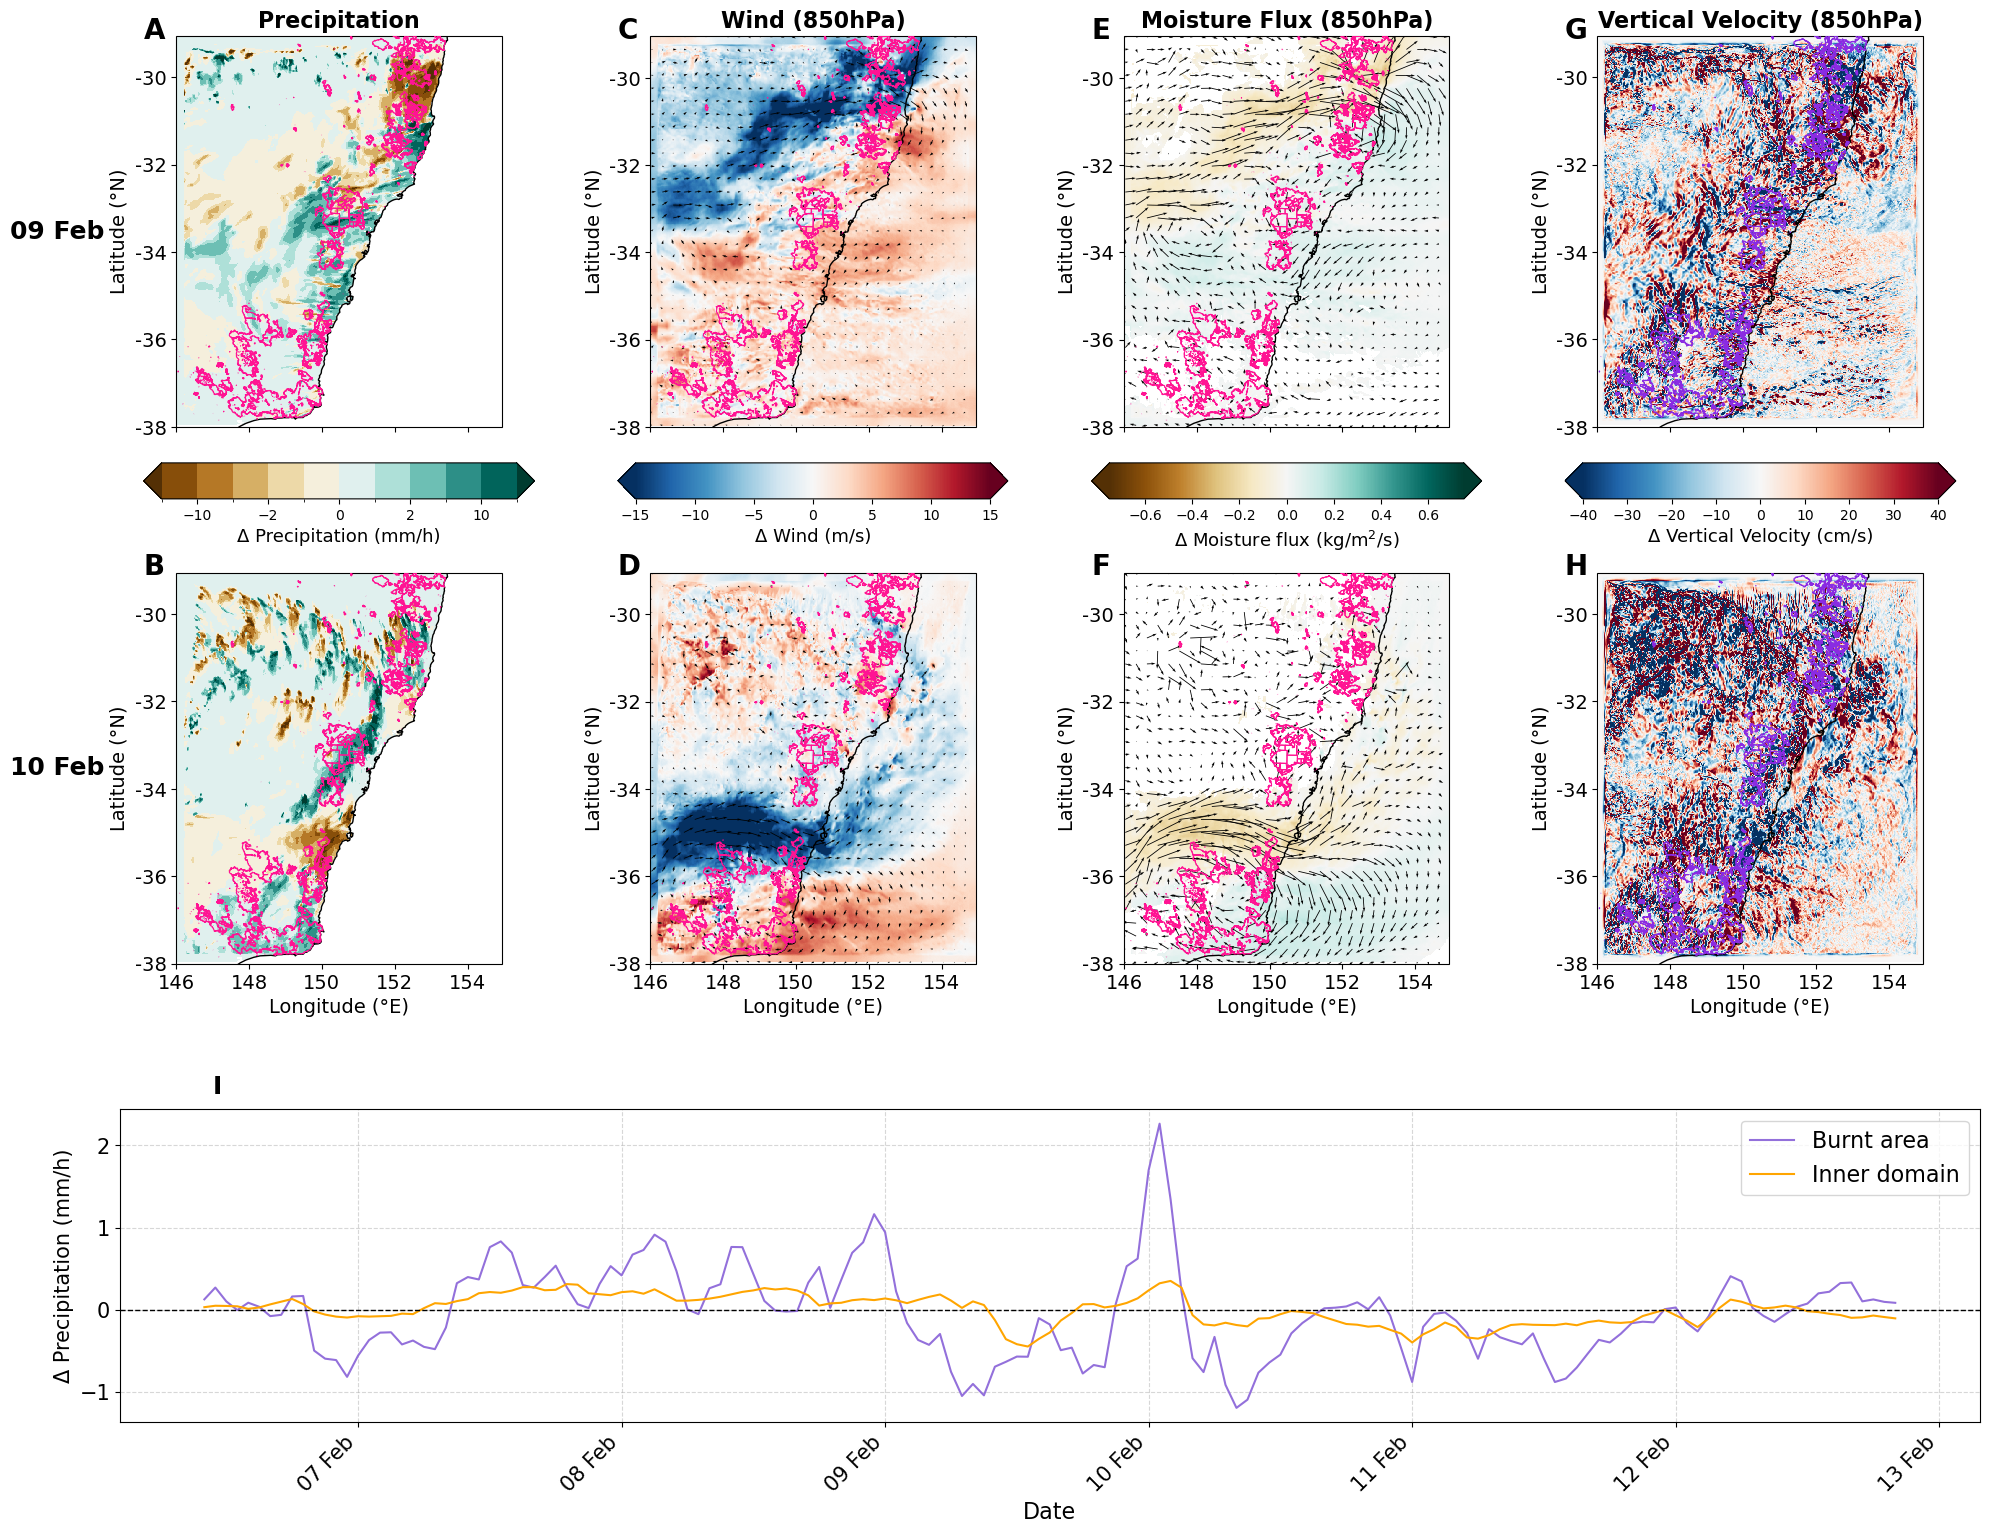

In [7]:
#absolute difference plot
fig = plt.figure(figsize=(24, 18))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 0.8], width_ratios=[1,1,1,1],
                       hspace=0.4, wspace=0.08)

start_date = "2020-02-07 00:00"
end_date = "2020-02-13 23:59"

proj = ccrs.PlateCarree()
labels = ["A","C","E","G","B","D","F","H", ]
dates = ["09 Feb", "10 Feb"]

times = ["2020-02-09T16:00", "2020-02-10T16:00"]
titles = ["4pm"]
levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]


#---diff rain for time series (converted to mm/h) ---
control_inner = (clipped["control"] * 3600).sel(time=slice(start_date, end_date))
SM_inner = (clipped["SM"] * 3600).sel(time=slice(start_date, end_date))
ts_diff_inner = (SM_inner - control_inner).mean(dim=["latitude", "longitude"], skipna=True)
dates_inner = pd.to_datetime(ts_diff_inner.time.values)

control_outer = (control_precip * 3600).sel(time=slice(start_date, end_date))
SM_outer = (SM_precip * 3600).sel(time=slice(start_date, end_date))
ts_diff_outer = (SM_outer - control_outer).mean(dim=["latitude", "longitude"], skipna=True)
dates_outer = pd.to_datetime(ts_diff_outer.time.values)


flux_control_masked = flux_control.where(flux_control > 0.1) 

selected_key = "SM"  
start_date = "2020-02-07 00:00"
end_date = "2020-02-13 23:59"
color_fire = "mediumpurple"
color_full = "orange"
skip = 15

#---loop over days (rows) and variables (columns) ---
days = [np.datetime64("2020-02-09T16:00"), np.datetime64("2020-02-10T16:00")]
for row_idx, target_time in enumerate(days):
    
    #---precip panel
    ax_precip = fig.add_subplot(gs[row_idx, 0], projection =proj)
    control_t = control_precip.sel(time=target_time, method='nearest')*3600
    SM_t = SM_precip.sel(time=target_time, method='nearest')*3600
    diff_precip = (SM_t - control_t).where(landmask==1)
    levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]

    cmap = plt.get_cmap("BrBG")
    norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N, extend='both')
    im_precip = ax_precip.pcolormesh(diff_precip.longitude, diff_precip.latitude, diff_precip,
                                     cmap=cmap, norm=norm, transform=proj)
    if row_idx == 0:
        ax_precip.set_title( "Precipitation", fontsize=16, fontweight ='bold')
        cbar_ax = fig.add_axes([ #cbar
            ax_precip.get_position().x0,      
            ax_precip.get_position().y0 -0.04, 
            ax_precip.get_position().width,   
            0.02                              
        ])
        cbar = fig.colorbar(im_precip, cax=cbar_ax, orientation="horizontal")
        cbar.set_label("Δ Precipitation (mm/h)", fontsize=13)
    fires_clipped.plot(ax=ax_precip, facecolor="none", edgecolor="deeppink", linewidth=0.8,
                   transform=ccrs.PlateCarree(), zorder=5)
    ax_precip.text(
        -0.1, 1.05, labels[row_idx*4 + 0],  #0 = precip column
        transform=ax_precip.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left', zorder=100
    )
    ax_precip.text(
        -0.22, 0.5, dates[row_idx],       #x < 0 moved it left outside axes
        transform=ax_precip.transAxes,
        fontsize=18, fontweight='bold',
        va='center', ha='right',          
        zorder=100,
        clip_on=False
    )

    ax_precip.coastlines(); ax_precip.add_feature(cfeature.BORDERS)
    ax_precip.set_ylabel("Latitude (°N)", fontsize=14)
    ax_precip.set_yticks(np.arange(-38, -28, 2), crs=proj)
    ax_precip.set_yticklabels([f"{lat}" for lat in np.arange(-38, -28, 2)], fontsize=14)
    if row_idx == 1:
        ax_precip.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_precip.set_xticklabels([f"{lon}" for lon in np.arange(146, 155, 2)], fontsize=14)
    else:
        ax_precip.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_precip.set_xticklabels([])

    
    #---------Wind panel--------
    ax_wind = fig.add_subplot(gs[row_idx, 1], projection=proj)
    speed_SM_plot = speed_SM.sel(time=target_time, method="nearest")
    speed_ctrl_plot = speed_control.sel(time=target_time, method="nearest")
    u_diff = u_wind_SM.sel(time=target_time) - u_wind_control.sel(time=target_time)
    v_diff = v_wind_SM.sel(time=target_time) - v_wind_control.sel(time=target_time)
    speed_diff = speed_SM_plot - speed_ctrl_plot
    im_wind = ax_wind.pcolormesh(speed_diff.longitude, speed_diff.latitude, speed_diff,
                                 cmap="RdBu_r", vmin=-15, vmax=15, transform=proj)
    ax_wind.quiver(speed_diff.longitude[::skip], speed_diff.latitude[::skip],
                   u_diff.values[::skip, ::skip], v_diff.values[::skip, ::skip],
                   transform=proj, color="black", scale=500)
    if row_idx == 0:
        ax_wind.set_title("Wind (850hPa)", fontsize=16, fontweight ='bold')
        cbar_ax = fig.add_axes([
            ax_wind.get_position().x0,      
            ax_wind.get_position().y0 -0.04,  
            ax_wind.get_position().width,   
            0.02                              
        ])
        cbar = fig.colorbar(im_wind, cax=cbar_ax, orientation="horizontal", extend = 'both')
        cbar.set_label("Δ Wind (m/s)", fontsize=13)
    fires_clipped.plot(ax=ax_wind, facecolor="none", edgecolor="deeppink", linewidth=0.8,
            transform=ccrs.PlateCarree(), zorder=5)
    ax_wind.coastlines(); ax_wind.add_feature(cfeature.BORDERS)
    ax_wind.text(
        -0.1, 1.05, labels[row_idx*4 + 1],  # 1 = wind column
        transform=ax_wind.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left', zorder=100
    )
    if row_idx == 1:
        ax_wind.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_wind.set_xticklabels([f"{lon}" for lon in np.arange(146, 155, 2)], fontsize=14)
    else:
        ax_wind.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_wind.set_xticklabels([])
    ax_wind.set_ylabel("Latitude (°N)", fontsize=14)
    ax_wind.set_yticks(np.arange(-38, -28, 2), crs=proj)
    ax_wind.set_yticklabels([f"{lat}" for lat in np.arange(-38, -28, 2)], fontsize=14)

    
    #------------Moisture flux panel--------
    ax_flux = fig.add_subplot(gs[row_idx, 2], projection=proj)
    flux_t = flux_SM.sel(time=target_time) - flux_control_masked.sel(time=target_time)
    u_diff_flux = experiments_u["SM"].sel(time=target_time) - experiments_u["Control"].sel(time=target_time)
    v_diff_flux = experiments_v["SM"].sel(time=target_time) - experiments_v["Control"].sel(time=target_time)
    im_flux = ax_flux.pcolormesh(flux_t.longitude, flux_t.latitude, flux_t,
                                 cmap="BrBG", vmin=-0.75, vmax=0.75, transform=proj)
    if row_idx == 0:
        ax_flux.set_title("Moisture Flux (850hPa)", fontsize = 16, fontweight ='bold')
        cbar_ax = fig.add_axes([
            ax_flux.get_position().x0,    
            ax_flux.get_position().y0 -0.04,
            ax_flux.get_position().width,   
            0.02                          
        ])
        cbar = fig.colorbar(im_flux, cax=cbar_ax, orientation="horizontal", extend = 'both')
        cbar.set_label("Δ Moisture flux (kg/$\mathregular{m^2}$/s)", fontsize=13)
    ax_flux.quiver(flux_t.longitude[::skip], flux_t.latitude[::skip],
                   u_diff_flux.values[::skip, ::skip], v_diff_flux.values[::skip, ::skip],
                   transform=proj, scale=200, width=0.0025, headwidth=3, color="black")
    fires_clipped.plot(ax=ax_flux, facecolor="none", edgecolor="deeppink", linewidth=0.8,
                   transform=ccrs.PlateCarree(), zorder=5)
    ax_flux.coastlines(); ax_flux.add_feature(cfeature.BORDERS)
    ax_flux.text(
        -0.1, 1.05, labels[row_idx*4 + 2],
        transform=ax_flux.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left', zorder=100
    )
    if row_idx == 1:
        ax_flux.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_flux.set_xticklabels([f"{lon}" for lon in np.arange(146, 155, 2)], fontsize=14)
    else:
        ax_flux.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_flux.set_xticklabels([])
    ax_flux.set_ylabel("Latitude (°N)", fontsize=14)
    ax_flux.set_yticks(np.arange(-38, -28, 2), crs=proj)
    ax_flux.set_yticklabels([f"{lat}" for lat in np.arange(-38, -28, 2)], fontsize=14)

    
    #------------Upward velocity panel-----------
    ax_w = fig.add_subplot(gs[row_idx, 3], projection=proj)
    control_w_plot = control_w.sel(time=target_time)
    sm_w_plot = sm_w.sel(time=target_time)
    w_diff = sm_w_plot - control_w_plot
    im_w = ax_w.pcolormesh(w_diff.longitude, w_diff.latitude, w_diff,
                           cmap='RdBu_r', vmin=-40, vmax=40, transform=proj)
    if row_idx == 0:
        cbar_ax = fig.add_axes([
            ax_w.get_position().x0,     
            ax_w.get_position().y0 -0.04,  
            ax_w.get_position().width,   
            0.02                              
        ])
        cbar = fig.colorbar(im_w, cax=cbar_ax, orientation="horizontal", extend = 'both')
        cbar.set_label("Δ Vertical Velocity (cm/s)", fontsize=13)
        ax_w.set_title("Vertical Velocity (850hPa)", fontsize = 16, fontweight ='bold')
    fires_clipped.plot(ax=ax_w, facecolor="none", edgecolor="blueviolet", linewidth=0.8,
            transform=ccrs.PlateCarree(), zorder=5)
    ax_w.coastlines(); ax_w.add_feature(cfeature.BORDERS)
    ax_w.text(
    -0.1, 1.05, labels[row_idx*4 + 3],  
    transform=ax_w.transAxes,
    fontsize=20, fontweight='bold',
    va='top', ha='left',
    zorder=100,
    clip_on=False
    )

    if row_idx == 1:
        ax_w.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_w.set_xticklabels([f"{lon}" for lon in np.arange(146, 155, 2)], fontsize=14)
    else:
        ax_w.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_w.set_xticklabels([])
    ax_w.set_ylabel("Latitude (°N)", fontsize=14)
    ax_w.set_yticks(np.arange(-38, -28, 2), crs=proj)
    ax_w.set_yticklabels([f"{lat}" for lat in np.arange(-38, -28, 2)], fontsize=14)
    

#---Time Series spanning all 4 columns ---
ax_ts = fig.add_subplot(gs[2, :])
ax_ts.plot(dates_inner, ts_diff_inner, label="Burnt area", color=color_fire)
ax_ts.plot(dates_outer, ts_diff_outer, label="Inner domain", color=color_full)

ax_ts.axhline(0, color="black", linewidth=1, linestyle="--")  # reference line
ax_ts.set_ylabel("Δ Precipitation (mm/h)", fontsize=15)
ax_ts.set_xlabel("Date", fontsize=16)
ax_ts.grid(True, linestyle='--', alpha=0.5)
ax_ts.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax_ts.xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.setp(ax_ts.get_xticklabels(), rotation=45, ha='right', fontsize=15)
ax_ts.text(
    0.05, 1.05, "I",
    transform=ax_ts.transAxes,
    fontsize=18,
    fontweight='bold',
    color='black'
)
ax_ts.tick_params(axis='y', labelsize=15)
ax_ts.legend(fontsize=16)

#xaxis labels on bottom row
if row_idx == 1: 
    ax_precip.set_xlabel("Longitude (°E)", fontsize=14)
    ax_wind.set_xlabel("Longitude (°E)", fontsize=14)
    ax_flux.set_xlabel("Longitude (°E)", fontsize=14)
    ax_w.set_xlabel("Longitude (°E)", fontsize=14)



# plt.savefig('/g/data/ng72/as9583/new_analysis/figures/large_scale_diff.png', dpi = 500, bbox_inches = "tight")
plt.show()


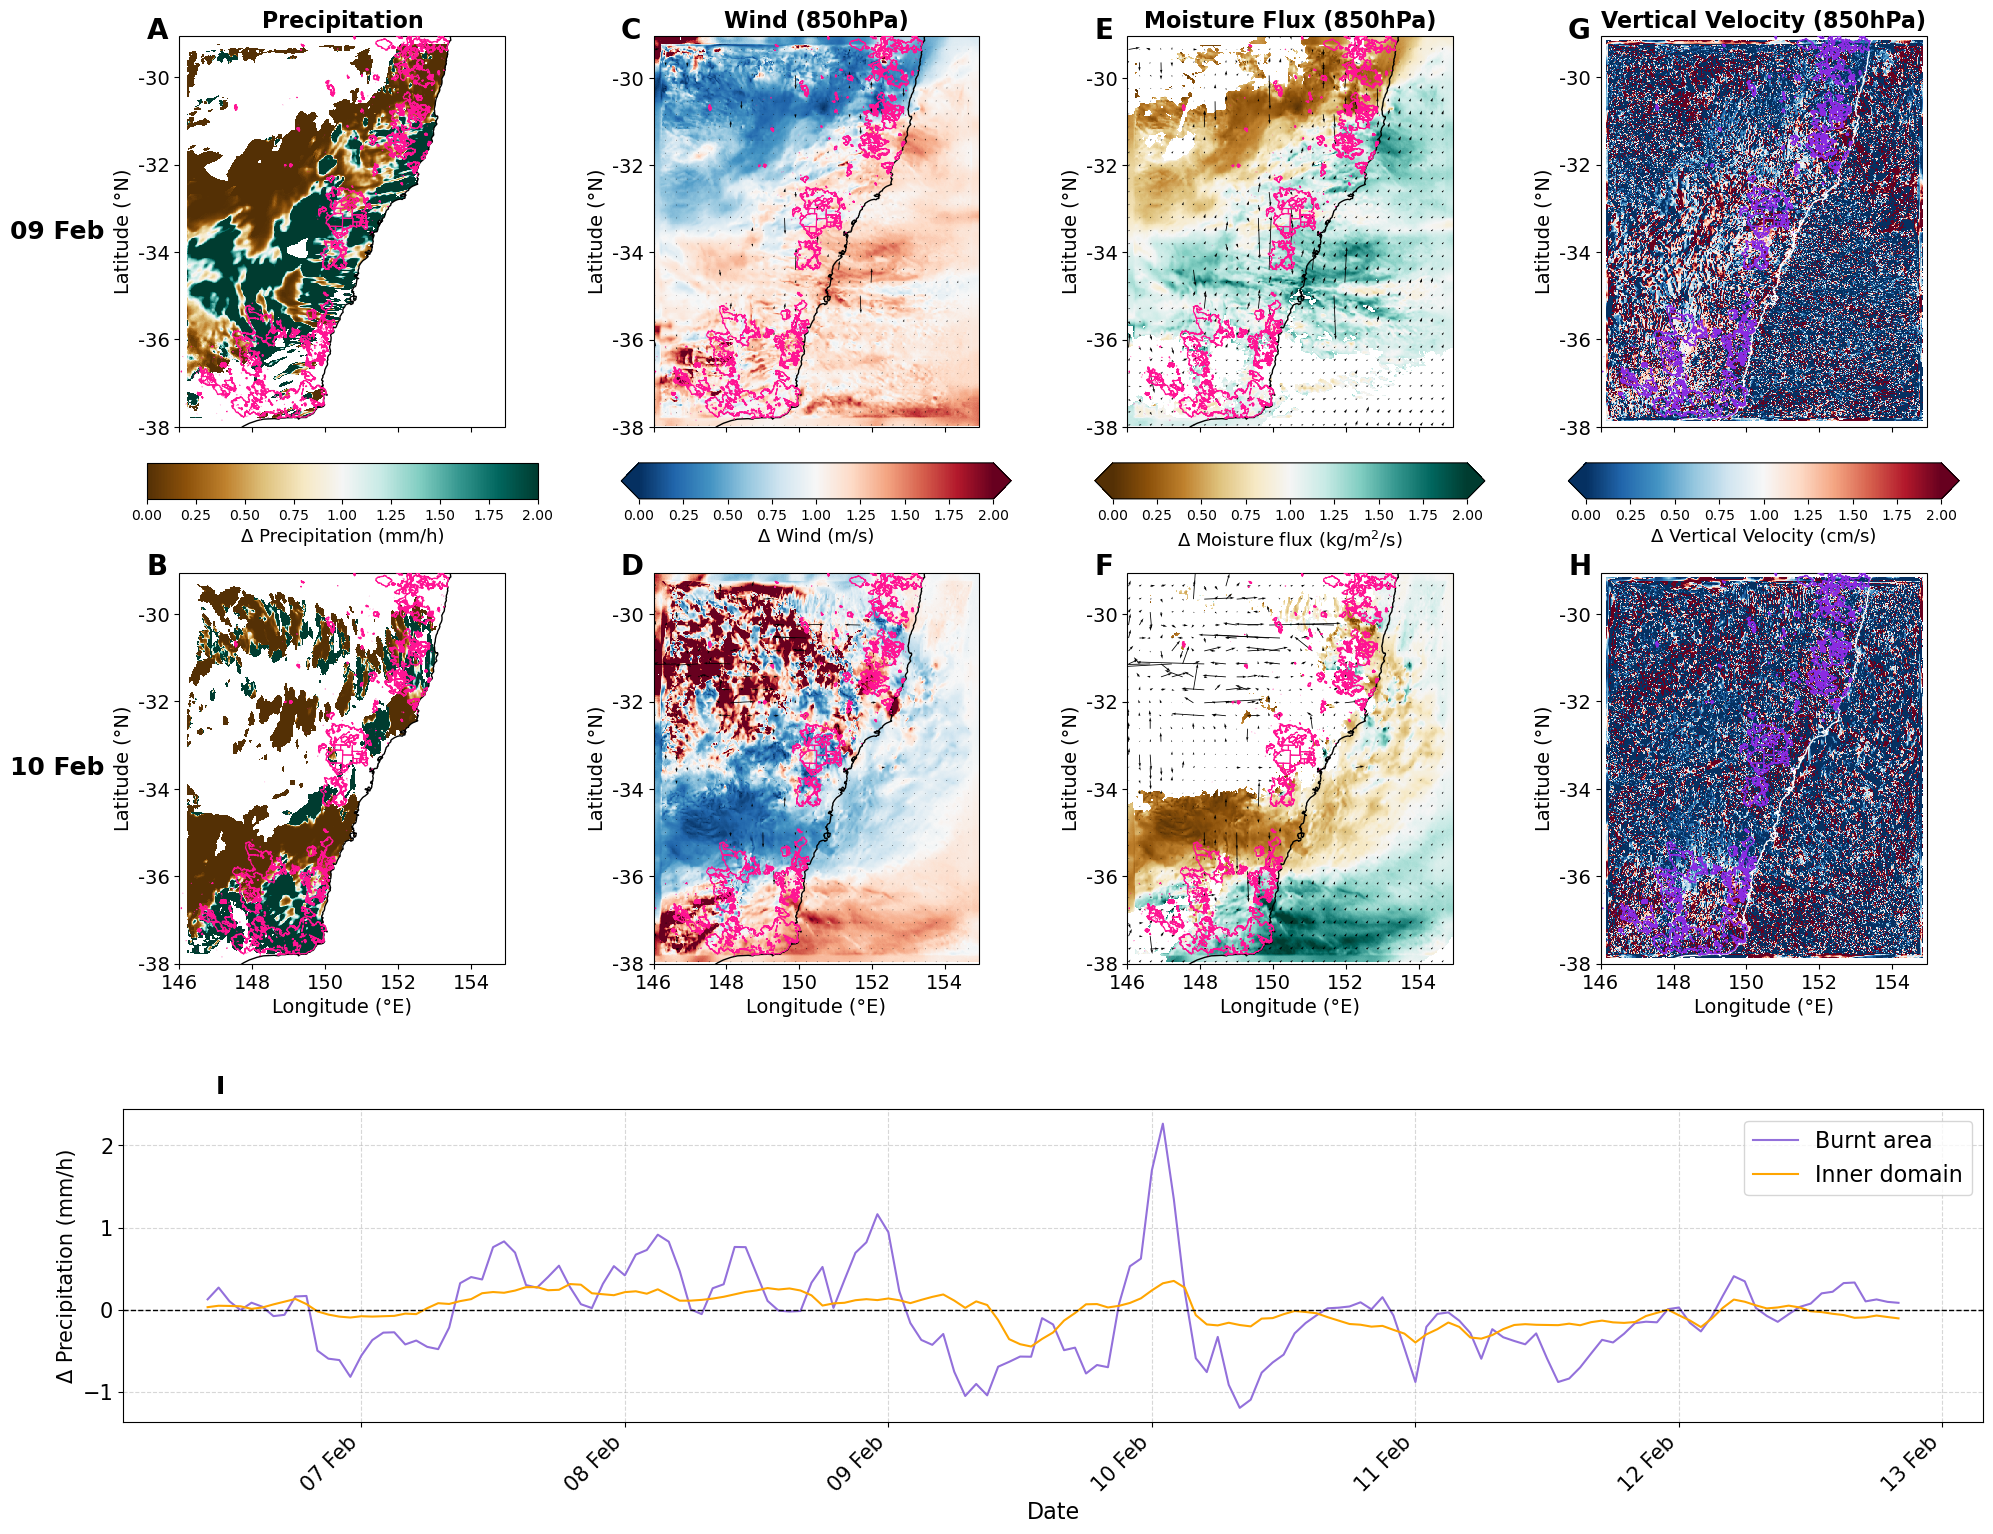

In [11]:
#relative diff
fig = plt.figure(figsize=(24, 18))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 0.8], width_ratios=[1,1,1,1],
                       hspace=0.4, wspace=0.08)

start_date = "2020-02-07 00:00"
end_date = "2020-02-13 23:59"

proj = ccrs.PlateCarree()
labels = ["A","C","E","G","B","D","F","H", ]
dates = ["09 Feb", "10 Feb"]

times = ["2020-02-09T16:00", "2020-02-10T16:00"]
titles = ["4pm"]
vmin, vmax = 0, 2



#---diff rain for time series (converted to mm/h) ---
control_inner = (clipped["control"] * 3600).sel(time=slice(start_date, end_date))
SM_inner = (clipped["SM"] * 3600).sel(time=slice(start_date, end_date))
ts_diff_inner = (SM_inner - control_inner).mean(dim=["latitude", "longitude"], skipna=True)
dates_inner = pd.to_datetime(ts_diff_inner.time.values)

control_outer = (control_precip * 3600).sel(time=slice(start_date, end_date))
SM_outer = (SM_precip * 3600).sel(time=slice(start_date, end_date))
ts_diff_outer = (SM_outer - control_outer).mean(dim=["latitude", "longitude"], skipna=True)
dates_outer = pd.to_datetime(ts_diff_outer.time.values)


flux_control_masked = flux_control.where(flux_control > 0.1) 

selected_key = "SM"  
start_date = "2020-02-07 00:00"
end_date = "2020-02-13 23:59"
color_fire = "mediumpurple"
color_full = "orange"
skip = 15

#---loop over days (rows) and variables (columns)---
days = [np.datetime64("2020-02-09T16:00"), np.datetime64("2020-02-10T16:00")]
for row_idx, target_time in enumerate(days):
    
    #---Precip panel
    ax_precip = fig.add_subplot(gs[row_idx, 0], projection =proj)
    control_t = control_precip.sel(time=target_time, method='nearest')*3600
    SM_t = SM_precip.sel(time=target_time, method='nearest')*3600
    diff_precip = (SM_t / control_t).where(landmask==1)
    levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]

    cmap = plt.get_cmap("BrBG")
    im_precip = ax_precip.pcolormesh(diff_precip.longitude, diff_precip.latitude, diff_precip,
                                     cmap=cmap, vmin = vmin, vmax = vmax, transform=proj)
    if row_idx == 0:
        ax_precip.set_title( "Precipitation", fontsize=16, fontweight ='bold')
        cbar_ax = fig.add_axes([
            ax_precip.get_position().x0,     
            ax_precip.get_position().y0 -0.04,  
            ax_precip.get_position().width, 
            0.02                        
        ])
        cbar = fig.colorbar(im_precip, cax=cbar_ax, orientation="horizontal")
        cbar.set_label("Δ Precipitation (mm/h)", fontsize=13)
    fires_clipped.plot(ax=ax_precip, facecolor="none", edgecolor="deeppink", linewidth=0.8,
                   transform=ccrs.PlateCarree(), zorder=5)
    ax_precip.text(
        -0.1, 1.05, labels[row_idx*4 + 0], 
        transform=ax_precip.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left', zorder=100
    )
    ax_precip.text(
        -0.23, 0.5, dates[row_idx],       
        transform=ax_precip.transAxes,
        fontsize=18, fontweight='bold',
        va='center', ha='right',      
        zorder=100,
        clip_on=False
    )

    ax_precip.coastlines(); ax_precip.add_feature(cfeature.BORDERS)
    ax_precip.set_ylabel("Latitude (°N)", fontsize=14)
    ax_precip.set_yticks(np.arange(-38, -28, 2), crs=proj)
    ax_precip.set_yticklabels([f"{lat}" for lat in np.arange(-38, -28, 2)], fontsize=14)
    if row_idx == 1:
        ax_precip.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_precip.set_xticklabels([f"{lon}" for lon in np.arange(146, 155, 2)], fontsize=14)
    else:
        ax_precip.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_precip.set_xticklabels([])

    
    #---------Wind panel--------
    ax_wind = fig.add_subplot(gs[row_idx, 1], projection=proj)
    speed_SM_plot = speed_SM.sel(time=target_time, method="nearest")
    speed_ctrl_plot = speed_control.sel(time=target_time, method="nearest")
    u_diff = u_wind_SM.sel(time=target_time) / u_wind_control.sel(time=target_time)
    v_diff = v_wind_SM.sel(time=target_time) / v_wind_control.sel(time=target_time)
    speed_diff = speed_SM_plot / speed_ctrl_plot
    im_wind = ax_wind.pcolormesh(speed_diff.longitude, speed_diff.latitude, speed_diff,
                                 cmap="RdBu_r", vmin = vmin, vmax = vmax, transform=proj)
    ax_wind.quiver(speed_diff.longitude[::skip], speed_diff.latitude[::skip],
                   u_diff.values[::skip, ::skip], v_diff.values[::skip, ::skip],
                   transform=proj, color="black", scale=500)
    if row_idx == 0:
        ax_wind.set_title("Wind (850hPa)", fontsize=16, fontweight ='bold')
        cbar_ax = fig.add_axes([
            ax_wind.get_position().x0,      
            ax_wind.get_position().y0 -0.04,
            ax_wind.get_position().width,  
            0.02                              
        ])
        cbar = fig.colorbar(im_wind, cax=cbar_ax, orientation="horizontal", extend = 'both')
        cbar.set_label("Δ Wind (m/s)", fontsize=13)
    fires_clipped.plot(ax=ax_wind, facecolor="none", edgecolor="deeppink", linewidth=0.8,
            transform=ccrs.PlateCarree(), zorder=5)
    ax_wind.coastlines(); ax_wind.add_feature(cfeature.BORDERS)
    ax_wind.text(
        -0.1, 1.05, labels[row_idx*4 + 1],  
        transform=ax_wind.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left', zorder=100
    )
    if row_idx == 1:
        ax_wind.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_wind.set_xticklabels([f"{lon}" for lon in np.arange(146, 155, 2)], fontsize=14)
    else:
        ax_wind.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_wind.set_xticklabels([])
    ax_wind.set_ylabel("Latitude (°N)", fontsize=14)
    ax_wind.set_yticks(np.arange(-38, -28, 2), crs=proj)
    ax_wind.set_yticklabels([f"{lat}" for lat in np.arange(-38, -28, 2)], fontsize=14)

    
    #------------Moisture flux panel--------
    ax_flux = fig.add_subplot(gs[row_idx, 2], projection=proj)
    flux_t = flux_SM.sel(time=target_time) / flux_control_masked.sel(time=target_time)
    u_diff_flux = experiments_u["SM"].sel(time=target_time) / experiments_u["Control"].sel(time=target_time)
    v_diff_flux = experiments_v["SM"].sel(time=target_time) / experiments_v["Control"].sel(time=target_time)
    im_flux = ax_flux.pcolormesh(flux_t.longitude, flux_t.latitude, flux_t,
                                 cmap="BrBG",vmin = vmin, vmax = vmax, transform=proj)
    if row_idx == 0:
        ax_flux.set_title("Moisture Flux (850hPa)", fontsize = 16, fontweight ='bold')
        cbar_ax = fig.add_axes([
            ax_flux.get_position().x0,     
            ax_flux.get_position().y0 -0.04, 
            ax_flux.get_position().width,  
            0.02                             
        ])
        cbar = fig.colorbar(im_flux, cax=cbar_ax, orientation="horizontal", extend = 'both')
        cbar.set_label("Δ Moisture flux (kg/$\mathregular{m^2}$/s)", fontsize=13)
    ax_flux.quiver(flux_t.longitude[::skip], flux_t.latitude[::skip],
                   u_diff_flux.values[::skip, ::skip], v_diff_flux.values[::skip, ::skip],
                   transform=proj, scale=200, width=0.0025, headwidth=3, color="black")
    fires_clipped.plot(ax=ax_flux, facecolor="none", edgecolor="deeppink", linewidth=0.8,
                   transform=ccrs.PlateCarree(), zorder=5)
    ax_flux.coastlines(); ax_flux.add_feature(cfeature.BORDERS)
    ax_flux.text(
        -0.1, 1.05, labels[row_idx*4 + 2],
        transform=ax_flux.transAxes,
        fontsize=20, fontweight='bold', va='top', ha='left', zorder=100
    )
    if row_idx == 1:
        ax_flux.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_flux.set_xticklabels([f"{lon}" for lon in np.arange(146, 155, 2)], fontsize=14)
    else:
        ax_flux.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_flux.set_xticklabels([])
    ax_flux.set_ylabel("Latitude (°N)", fontsize=14)
    ax_flux.set_yticks(np.arange(-38, -28, 2), crs=proj)
    ax_flux.set_yticklabels([f"{lat}" for lat in np.arange(-38, -28, 2)], fontsize=14)

    
    #------------Upward velocity panel-----------
    ax_w = fig.add_subplot(gs[row_idx, 3], projection=proj)
    control_w_plot = control_w.sel(time=target_time)
    sm_w_plot = sm_w.sel(time=target_time)
    w_diff = sm_w_plot / control_w_plot
    im_w = ax_w.pcolormesh(w_diff.longitude, w_diff.latitude, w_diff,
                           cmap='RdBu_r',vmin = vmin, vmax = vmax, transform=proj)
    if row_idx == 0:
        cbar_ax = fig.add_axes([
            ax_w.get_position().x0,     
            ax_w.get_position().y0 -0.04,  
            ax_w.get_position().width,   
            0.02                              
        ])
        cbar = fig.colorbar(im_w, cax=cbar_ax, orientation="horizontal", extend = 'both')
        cbar.set_label("Δ Vertical Velocity (cm/s)", fontsize=13)
        ax_w.set_title("Vertical Velocity (850hPa)", fontsize = 16, fontweight ='bold')
    fires_clipped.plot(ax=ax_w, facecolor="none", edgecolor="blueviolet", linewidth=0.8,
            transform=ccrs.PlateCarree(), zorder=5)
    ax_w.coastlines(color='white', linewidth=1); ax_w.add_feature(cfeature.BORDERS, edgecolor='white')
    ax_w.text(
    -0.1, 1.05, labels[row_idx*4 + 3], 
    transform=ax_w.transAxes,
    fontsize=20, fontweight='bold',
    va='top', ha='left',
    zorder=100,
    clip_on=False
    )

    if row_idx == 1:
        ax_w.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_w.set_xticklabels([f"{lon}" for lon in np.arange(146, 155, 2)], fontsize=14)
    else:
        ax_w.set_xticks(np.arange(146, 155, 2), crs=proj)
        ax_w.set_xticklabels([])
    ax_w.set_ylabel("Latitude (°N)", fontsize=14)
    ax_w.set_yticks(np.arange(-38, -28, 2), crs=proj)
    ax_w.set_yticklabels([f"{lat}" for lat in np.arange(-38, -28, 2)], fontsize=14)
    

#---Time Series---
ax_ts = fig.add_subplot(gs[2, :])
ax_ts.plot(dates_inner, ts_diff_inner, label="Burnt area", color=color_fire)
ax_ts.plot(dates_outer, ts_diff_outer, label="Inner domain", color=color_full)

ax_ts.axhline(0, color="black", linewidth=1, linestyle="--")  # reference line
ax_ts.set_ylabel("Δ Precipitation (mm/h)", fontsize=15)
ax_ts.set_xlabel("Date", fontsize=16)
ax_ts.grid(True, linestyle='--', alpha=0.5)
ax_ts.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
ax_ts.xaxis.set_major_locator(mdates.HourLocator(interval=24))
plt.setp(ax_ts.get_xticklabels(), rotation=45, ha='right', fontsize=15)
ax_ts.text(
    0.05, 1.05, "I",
    transform=ax_ts.transAxes,
    fontsize=18,
    fontweight='bold',
    color='black'
)
ax_ts.tick_params(axis='y', labelsize=15)
ax_ts.legend(fontsize=16)

#xaxis on bottom row
if row_idx == 1: 
    ax_precip.set_xlabel("Longitude (°E)", fontsize=14)
    ax_wind.set_xlabel("Longitude (°E)", fontsize=14)
    ax_flux.set_xlabel("Longitude (°E)", fontsize=14)
    ax_w.set_xlabel("Longitude (°E)", fontsize=14)



# plt.savefig('/g/data/ng72/as9583/new_analysis/figures/large_scale_diff_relative2.png', dpi = 500, bbox_inches = "tight")
plt.show()
